# Armis Data Hack Challenge - Itzikim Solution

# Imports and Consts

In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import turicreate as tc
from urllib import request
import json
from itertools import product
import random

In [2]:
random_state=666
random.seed(random_state)
np.random.seed(random_state)

In [3]:
DATA_PREFIX = "../../"

In [4]:
DEVICES_PATH = DATA_PREFIX+"all_devices.csv"
SESSIONS_PATH = DATA_PREFIX+"all_sessions.csv"
ROUTER_PATH = DATA_PREFIX+"is_router.csv"
BYOD_PATH = DATA_PREFIX+"unique_models_byod.csv"

## Read the data

In [5]:
devices = pd.read_csv(DEVICES_PATH).drop('Unnamed: 0',axis=1)
devices.head()

,network_id,device_id,type,model,manufacturer,operating_system,operating_system_version
0,0,1028623,MOBILE_PHONE,Galaxy S8,Samsung,Android,9
1,0,48047,MOBILE_PHONE,Galaxy Note 8,Samsung,Android,9
2,0,123568,MOBILE_PHONE,H918,LG Electronics,Android,8.0.0
3,0,95366,MOBILE_PHONE,iPhone 6,"Apple, Inc.",iOS,NaN
4,0,1755023,TABLET,iPad,Apple,iOS,NaN


In [6]:
sessions = pd.read_csv(SESSIONS_PATH).drop('Unnamed: 0',axis=1)
sessions.head()

,network_id,device_id,timestamp,host,host_ip,port_dst,transport_protocol,service_device_id,packets_count,outbound_bytes_count,...,outbound_packet_size_max,outbound_packet_size_min,outbound_packet_size_mean,outbound_packet_size_median,outbound_packet_size_stddev,inbound_packet_size_max,inbound_packet_size_min,inbound_packet_size_mean,inbound_packet_size_median,inbound_packet_size_stddev
0,0,35,1565074800,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,49152,TCP,790889.0,260,21855,...,93.000000,93.000000,93.000000,93.000000,0.000000,312.6,312.6,312.6,312.6,0.0
1,0,35,1565053200,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,49153,TCP,1604622.0,178,8326,...,106.750000,93.400000,94.883333,93.000000,4.317134,318.4,318.4,318.4,318.0,0.0
2,0,57,1565082000,e16257c983f2c35d41f39d425651972fa1905e46e968d7...,d43dad76e6cef2231d2efc743e498996b40f8b13fc120b...,443,TCP,NaN,67,4013,...,64.018182,41.000000,44.288312,41.000000,8.700055,NaN,NaN,NaN,NaN,NaN
3,0,57,1565082000,1a4f860269acca6c264f00d84c4b63aad00b8f93a77250...,945e37dab8aee93dd4e650f8d17d76a3adfbc6aa70ebba...,443,TCP,NaN,45,9158,...,226.733333,133.571429,194.968236,209.000000,41.777266,NaN,NaN,NaN,NaN,NaN
4,0,57,1565082000,df106cbe1ba4a700c00ec8883490f40a8afdb75c15a9ea...,4b43e85e630c2d18a0afaa2a6366367c4fc52d32b4ba5b...,443,TCP,NaN,9,1671,...,185.666667,185.666667,185.666667,185.666667,NaN,NaN,NaN,NaN,NaN,NaN


## Clean

In [7]:
def remove_stopwords(x):
    x = str(x)
    x = x.lower()
    
    stopwords = ['inc', 'ltd', 'corporation', 'corporate', 'corp', 'co', 'gmbh', 'limited', ',', '.']
    for word in stopwords:
        x = x.replace(word, '')
    
    return x.strip()

def to_float(x):
    try:
        return float(x)
    except:
        return x

In [8]:
devices['manufacturer'] = devices['manufacturer'].apply(remove_stopwords)

## Analysis based features (tagged by domain expertise)

In [9]:
router_data = pd.read_csv(ROUTER_PATH)
router_data['is_router_no_yes_maybe']=router_data['is_router_no_yes_maybe'].astype(str)
router_data.head()

,name,is_router_no_yes_maybe
0,ZebraNet Wired PS,0
1,Zebra Wireless,2
2,"Xerox WorkCentre 5335;System 53.32.93,ESS1.205...",0
3,Windows Phone,0
4,Windows Mobile,0


In [10]:
byod_data = pd.read_csv(BYOD_PATH).drop('Unnamed: 2',axis=1)
byod_data['BYOD_no_yes_maybe']=byod_data['BYOD_no_yes_maybe'].astype(str)
byod_data.head()

,name,BYOD_no_yes_maybe
0,ZUK Z2 Plus,1.0
1,ZT410,0.0
2,ZMAX Pro,1.0
3,Zmax One,1.0
4,Zmax Champ,1.0


In [11]:
version_counts = devices.groupby(['operating_system','operating_system_version']).size().reset_index()
version_counts['is_infreq_ver'] = (version_counts[0] < 5).astype(int)
version_counts = version_counts.drop(0,axis=1)

In [12]:
manuos_counts = devices.groupby(['manufacturer','operating_system']).size().reset_index()
manuos_counts['manuos_counts'] = manuos_counts[0]
manuos_counts['is_infreq_manous'] = (manuos_counts[0] < 2).astype(int)
manuos_counts = manuos_counts.drop(0,axis=1)

In [13]:
manuf_counts = devices.groupby(['manufacturer']).size().reset_index()
manuf_counts['manuf_count'] = manuf_counts[0]
manuf_counts = manuf_counts.drop(0,axis=1)

In [14]:
devices_enriched = devices \
    .merge(router_data,how="left",left_on='operating_system', right_on='name').drop("name",axis=1) \
    .merge(byod_data,how="left",left_on='model', right_on='name').drop("name",axis=1) \
    .merge(version_counts,how="left",left_on=['operating_system','operating_system_version'], right_on=['operating_system','operating_system_version']) \
    .merge(manuos_counts,how="left",left_on=['manufacturer', 'operating_system'], right_on=['manufacturer', 'operating_system']) \
    .merge(manuf_counts,how="left",left_on='manufacturer', right_on='manufacturer') 

In [15]:
devices_enriched['is_apple_disc']=((devices_enriched['operating_system_version']=="12.3.1") & (devices_enriched['manufacturer'] != "apple")).astype(int)
devices_enriched['manous_ratio'] = devices_enriched['manuos_counts'] / devices_enriched['manuf_count']

In [16]:
sessions['is_tcp']=(sessions['transport_protocol']=='TCP').astype(int)
sessions['is_self']=(sessions['host']==sessions['host_ip']).astype(int)
sessions['is_service_null']=(sessions['service_device_id'].isna()).astype(int)
sessions['is_port_80']=(sessions['port_dst']==80).astype(int)
sessions['is_port_443']=(sessions['port_dst']==443).astype(int)
sessions['is_port_53']=(sessions['port_dst']==53).astype(int)
sessions['inbound_outbount_packet_count_ratio']=(sessions['inbound_packets_count']/sessions['outbound_packets_count'])
sessions['inbound_outbount_packet_mean_ratio']=(sessions['inbound_packet_size_mean']/sessions['outbound_packet_size_mean'])
sessions['inbound_packet_bytes_ratio']=(sessions['inbound_packets_count']/sessions['inbound_bytes_count'])
sessions['outbound_packet_bytes_ratio']=(sessions['outbound_packets_count']/sessions['outbound_bytes_count'])
sessions['date'] = pd.to_datetime(sessions['timestamp'],unit='s')
sessions['hour'] = sessions['date'].dt.hour
sessions['dow'] = sessions['date'].dt.dayofweek

In [17]:
port_counts = sessions.groupby(['port_dst','transport_protocol']).size().reset_index()
port_counts['port_counts'] = port_counts[0]
port_counts['is_infreq_port'] = (port_counts[0] < 100).astype(int)
port_counts = port_counts.drop(0,axis=1)

## Merge frames 

In [18]:
merged = sessions \
    .merge(devices_enriched, how="left", left_on=['network_id','device_id'], right_on=['network_id','device_id'])\
    .merge(port_counts,how="left",left_on=['port_dst','transport_protocol'], right_on=['port_dst','transport_protocol']) \

In [19]:
print(sessions.shape)
print(merged.shape)

(22517480, 50)
(22517480, 65)


In [20]:
merged.head()

,network_id,device_id,timestamp,host,host_ip,port_dst,transport_protocol,service_device_id,packets_count,outbound_bytes_count,...,is_router_no_yes_maybe,BYOD_no_yes_maybe,is_infreq_ver,manuos_counts,is_infreq_manous,manuf_count,is_apple_disc,manous_ratio,port_counts,is_infreq_port
0,0,35,1565074800,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,49152,TCP,790889.0,260,21855,...,0,0.0,0.0,109.0,0.0,109,0,1.0,29260,0
1,0,35,1565053200,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,49153,TCP,1604622.0,178,8326,...,0,0.0,0.0,109.0,0.0,109,0,1.0,12884,0
2,0,57,1565082000,e16257c983f2c35d41f39d425651972fa1905e46e968d7...,d43dad76e6cef2231d2efc743e498996b40f8b13fc120b...,443,TCP,NaN,67,4013,...,0,0.0,0.0,569.0,0.0,569,0,1.0,12873196,0
3,0,57,1565082000,1a4f860269acca6c264f00d84c4b63aad00b8f93a77250...,945e37dab8aee93dd4e650f8d17d76a3adfbc6aa70ebba...,443,TCP,NaN,45,9158,...,0,0.0,0.0,569.0,0.0,569,0,1.0,12873196,0
4,0,57,1565082000,df106cbe1ba4a700c00ec8883490f40a8afdb75c15a9ea...,4b43e85e630c2d18a0afaa2a6366367c4fc52d32b4ba5b...,443,TCP,NaN,9,1671,...,0,0.0,0.0,569.0,0.0,569,0,1.0,12873196,0


## Merged- Analysis based features - suspicous activites

In [21]:
# handcrafted  :

suspects = merged[(merged['BYOD_no_yes_maybe'] == "0.0") & (merged['service_device_id'].isna())]
suspects = set(suspects['device_id'].unique())
merged['outbound_company_device'] = merged['device_id'].apply(lambda x: int(x in suspects))

suspects = merged[(merged['BYOD_no_yes_maybe'] == "0.0") & (merged['service_device_id'].isna()) & (merged['port_dst'] == 53)]
suspects = set(suspects['device_id'].unique())
merged['outbound_company_device_53'] = merged['device_id'].apply(lambda x: int(x in suspects))

suspects = merged[(merged['BYOD_no_yes_maybe'] == "2.0") & (merged['service_device_id'].isna()) & (merged['port_dst'] == 53)]
suspects = set(suspects['device_id'].unique())
merged['maybe_outbound_company_device_53'] = merged['device_id'].apply(lambda x: int(x in suspects))

suspects = merged[(merged['BYOD_no_yes_maybe'] == "2.0") & (merged['service_device_id'].isna())]
suspects = set(suspects['device_id'].unique())
merged['maybe_outbound_company_device'] = merged['device_id'].apply(lambda x: int(x in suspects))

merged['is_to_port_67'] = (merged['port_dst'] == 67).astype(int)

In [22]:
merged.head()

,network_id,device_id,timestamp,host,host_ip,port_dst,transport_protocol,service_device_id,packets_count,outbound_bytes_count,...,manuf_count,is_apple_disc,manous_ratio,port_counts,is_infreq_port,outbound_company_device,outbound_company_device_53,maybe_outbound_company_device_53,maybe_outbound_company_device,is_to_port_67
0,0,35,1565074800,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,49152,TCP,790889.0,260,21855,...,109,0,1.0,29260,0,1,0,0,0,0
1,0,35,1565053200,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,49153,TCP,1604622.0,178,8326,...,109,0,1.0,12884,0,1,0,0,0,0
2,0,57,1565082000,e16257c983f2c35d41f39d425651972fa1905e46e968d7...,d43dad76e6cef2231d2efc743e498996b40f8b13fc120b...,443,TCP,NaN,67,4013,...,569,0,1.0,12873196,0,1,0,0,0,0
3,0,57,1565082000,1a4f860269acca6c264f00d84c4b63aad00b8f93a77250...,945e37dab8aee93dd4e650f8d17d76a3adfbc6aa70ebba...,443,TCP,NaN,45,9158,...,569,0,1.0,12873196,0,1,0,0,0,0
4,0,57,1565082000,df106cbe1ba4a700c00ec8883490f40a8afdb75c15a9ea...,4b43e85e630c2d18a0afaa2a6366367c4fc52d32b4ba5b...,443,TCP,NaN,9,1671,...,569,0,1.0,12873196,0,1,0,0,0,0


## Graph Based Features

In [54]:
!pip install turicreate

In [122]:
sf_devices = tc.SFrame(DEVICES_PATH)
sf_sessions = tc.SFrame(SESSIONS_PATH)

sf_networks = {}

for i in tqdm(range(4)):
    d = sf_devices[sf_devices['network_id'] == i]
    s = sf_sessions[sf_sessions['network_id'] == i]
    n = d.join(s, how='left', on='device_id')
    
    if len(n) > 0:
        sf_networks[i] = n
        
graphs = {}
for i, n in tqdm(sf_networks.items()):
    n['service_device_id'] = n['service_device_id'].fillna(-1).astype(int)
    graphs[i] = tc.SGraph(edges=n, src_field='device_id', dst_field='service_device_id')
    
graph_features = {}
for i, g in tqdm(graphs.items()):
    pr = tc.graph_analytics.pagerank.create(g)
    f = pr.pagerank.rename({'__id': 'device_id'})
    f = f.sort('device_id')
    
    dc = tc.graph_analytics.degree_counting.create(g)
    dc = dc.graph.vertices.rename({'__id': 'device_id'})
    dc = dc.sort('device_id')
    f['in_degree'] = dc['in_degree']
    f['out_degree'] = dc['out_degree']
    f['total_degree'] = dc['total_degree']
    
    gc = tc.graph_analytics.graph_coloring.create(g)
    gc = gc.graph.vertices.rename({'__id': 'device_id'})
    gc = gc.sort('device_id')
    f['color_id'] = gc['color_id']
    
    kc = tc.graph_analytics.kcore.create(g)
    kc = kc.graph.vertices.rename({'__id': 'device_id'})
    kc = kc.sort('device_id')
    f['core_id'] = kc['core_id']
    
    trc = tc.graph_analytics.triangle_counting.create(g)
    trc = trc.graph.vertices.rename({'__id': 'device_id'})
    trc = trc.sort('device_id')
    f['triangle_count'] = trc['triangle_count']
    
    f['network_id'] = i
    graph_features[i] = f


In [73]:
graph_features[0].head()

device_id,pagerank,delta,in_degree,out_degree,total_degree,color_id,core_id
-1,3073.0114922838125,1.6510713066963945e-05,7275320,0,7275320,6.0,10
29,0.15214285714285716,0.0,2,0,2,1.0,2
33,0.15,0.0,0,113,113,0.0,10
35,0.15,0.0,0,7607,7607,3.0,10
40,0.15,0.0,0,2903,2903,3.0,10
41,0.15,0.0,0,196,196,0.0,10
42,0.15076416109058088,0.0,62,0,62,0.0,10
53,0.15,0.0,0,1,1,0.0,1
55,0.15,0.0,0,1,1,0.0,1
57,0.15,0.0,0,4897,4897,0.0,10


In [62]:
## Backup graph features
# for i in range(4):
#     graph_features[i].to_dataframe().to_csv(DATA_PREFIX+"backup_graph_features_" + str(i) + ".csv", index=False)

## Aggregated features

In [23]:
categorical_types = ['object']

def get_categorical_data(data):
    return data.select_dtypes(categorical_types)

def get_numerical_data(data):
    return data.select_dtypes(exclude=categorical_types)

def concat_dfs(df1, df2):
    if df1 is None:
        return df2
    if df2 is None:
        return df1
    df1_no_index = df1.reset_index(drop=True, inplace=False)
    df2_no_index = df2.reset_index(drop=True, inplace=False)
    concated_data = pd.concat([df1_no_index, df2_no_index], axis=1)
    return concated_data

In [24]:
def extract_features(df, grouped_field_list, is_time=True):
    feat_dict = {
                "host": {"nunique"},
                "host_ip": {"nunique"},
                "port_dst": "nunique", 
                "packets_count": {"mean"}, 
                "is_self": {"mean"}, 
                "is_service_null": {"mean"}, 
                "inbound_outbount_packet_mean_ratio": {"mean"},
                "packet_loss": {"mean"}, 
                "retransmit_count": {"mean"}, 
                "latency": {"mean"}, 
                "session_count": {"mean"}, 
                "inbound_packets_count": {"mean"}, 
                "outbound_packets_count": {"mean"},
                "is_router_no_yes_maybe" : {"unique"},
                "BYOD_no_yes_maybe" : {"unique"},
                "is_infreq_ver" : {"mean"},
                "is_infreq_manous" : {"mean"},
                "manous_ratio" : {"mean"},
                "is_infreq_port" : {"mean"},        
                "outbound_company_device" : {"mean"},
                "outbound_company_device_53" : {"mean"},
                "maybe_outbound_company_device_53" : {"mean"},
                "maybe_outbound_company_device" : {"mean"},
                "is_to_port_67" : {"mean"}
               }
    if not is_time:
        feat_dict.update({
                          "type" : {"unique"}
                         })
    return df.groupby([*grouped_field_list]).aggregate(feat_dict)

In [25]:
def run_group_aggregation(df, grouping_set, is_time=False):
    aggs = []
    for i in range(4):
        # extract features
        aggs.append(extract_features(df[df.network_id == i], grouping_set, is_time=is_time))
        # Get the value out of the lists that the "unique" func in pd.aggregate creates
        for col in get_categorical_data(aggs[i]).columns.values:
            aggs[i][col] = aggs[i][col].apply(lambda x: x[0])
        # reset device_id as index
        aggs[i] = aggs[i].reset_index()
        # flatten after agg
        aggs[i].columns = ['_'.join(cols) if len(cols[1]) > 0 else cols[0] for cols in aggs[i].columns]
        # add features 
        aggs[i]['hosts_ratios'] = aggs[i]['host_ip_nunique']/aggs[i]['host_nunique']
    
    return aggs

### Temporally normalized data

In [26]:
timed_aggs = run_group_aggregation(merged, ['network_id','type','dow','hour'], is_time=True)

In [27]:
timed_aggs[0].head()

,network_id,type,dow,hour,retransmit_count_mean,inbound_packets_count_mean,outbound_packets_count_mean,is_to_port_67_mean,is_service_null_mean,latency_mean,...,is_infreq_manous_mean,is_router_no_yes_maybe_unique,maybe_outbound_company_device_53_mean,inbound_outbount_packet_mean_ratio_mean,outbound_company_device_mean,maybe_outbound_company_device_mean,host_nunique,packet_loss_mean,packets_count_mean,hosts_ratios
0,0,IP_CAMERA,0,7,0.013158,24.188158,385.101316,0.001316,0.540789,NaN,...,0.001524,0,0.003947,1.038501,0.878947,0.003947,12,0.000000,409.289474,1.0
1,0,IP_CAMERA,0,8,0.018996,13.216418,393.453867,0.000000,0.654681,1.0,...,0.006173,0,0.002714,1.004313,0.896879,0.013569,14,0.000032,406.670285,1.0
2,0,IP_CAMERA,0,9,0.007055,26.465021,372.319224,0.004115,0.660200,NaN,...,0.005814,0,0.001176,1.014848,0.814815,0.008230,12,0.000000,398.784245,1.0
3,0,IP_CAMERA,0,10,0.002853,1.182596,243.206847,0.001427,0.589158,1.0,...,0.005181,0,0.003566,1.070512,0.849501,0.009272,16,0.000000,244.389444,1.0
4,0,IP_CAMERA,0,11,0.010259,1.110616,271.808207,0.000000,0.601695,1.0,...,0.005535,0,0.003122,1.053159,0.794826,0.004014,36,0.000190,272.918822,1.0


In [28]:
timed_all = pd.concat([timed_aggs[i] for i in range(4)])
time_normalized = merged.merge(timed_all, how="left", left_on=['network_id','type','dow','hour'], right_on=['network_id','type','dow','hour'])

In [29]:
time_normalized['packets_count'] = time_normalized['packets_count'] - time_normalized['packets_count_mean']
time_normalized['is_self'] = time_normalized['is_self'] - time_normalized['is_self_mean']
time_normalized['is_service_null'] = time_normalized['is_service_null'] - time_normalized['is_service_null_mean']
time_normalized['inbound_outbount_packet_mean_ratio'] = time_normalized['inbound_outbount_packet_mean_ratio'] - time_normalized['inbound_outbount_packet_mean_ratio_mean']
time_normalized['packet_loss'] = time_normalized['packet_loss'] - time_normalized['packet_loss_mean']
time_normalized['retransmit_count'] = time_normalized['retransmit_count'] - time_normalized['retransmit_count_mean']
time_normalized['latency'] = time_normalized['latency'] - time_normalized['latency_mean']
time_normalized['session_count'] = time_normalized['session_count'] - time_normalized['session_count_mean']
time_normalized['inbound_packets_count'] = time_normalized['inbound_packets_count'] - time_normalized['inbound_packets_count_mean']
time_normalized['outbound_packets_count'] = time_normalized['outbound_packets_count'] - time_normalized['outbound_packets_count_mean']
time_normalized['is_infreq_ver'] = time_normalized['is_infreq_ver'] - time_normalized['is_infreq_ver_mean']
time_normalized['is_infreq_manous'] = time_normalized['is_infreq_manous'] - time_normalized['is_infreq_manous_mean']
time_normalized['manous_ratio'] = time_normalized['manous_ratio'] - time_normalized['manous_ratio_mean']
time_normalized['is_infreq_port'] = time_normalized['is_infreq_port'] - time_normalized['is_infreq_port_mean']
time_normalized['outbound_company_device'] = time_normalized['outbound_company_device'] - time_normalized['outbound_company_device_mean']
time_normalized['outbound_company_device_53'] = time_normalized['outbound_company_device_53'] - time_normalized['outbound_company_device_53_mean']
time_normalized['maybe_outbound_company_device_53'] = time_normalized['maybe_outbound_company_device_53'] - time_normalized['maybe_outbound_company_device_53_mean']
time_normalized['maybe_outbound_company_device'] = time_normalized['maybe_outbound_company_device'] - time_normalized['maybe_outbound_company_device_mean']
time_normalized['is_to_port_67'] = time_normalized['is_to_port_67'] - time_normalized['is_to_port_67_mean']

In [30]:
time_normalized.head()

,network_id,device_id,timestamp,host,host_ip,port_dst,transport_protocol,service_device_id,packets_count,outbound_bytes_count,...,is_infreq_manous_mean,is_router_no_yes_maybe_unique,maybe_outbound_company_device_53_mean,inbound_outbount_packet_mean_ratio_mean,outbound_company_device_mean,maybe_outbound_company_device_mean,host_nunique,packet_loss_mean,packets_count_mean,hosts_ratios
0,0,35,1565074800,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,ecbb92cd941972b779d18451b6f96275587941e4cf07a1...,49152,TCP,790889.0,27.833620,21855,...,0.000304,0,0.016905,2.918608,0.084556,0.259473,2905,0.034800,232.166380,1.116695
1,0,35,1565053200,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,90cf529b11c8f26efbb3936c7d10a5bf57c1a930603af0...,49153,TCP,1604622.0,-78.403501,8326,...,0.000229,0,0.021691,3.051656,0.096221,0.270833,2757,0.038072,256.403501,1.117519
2,0,57,1565082000,e16257c983f2c35d41f39d425651972fa1905e46e968d7...,d43dad76e6cef2231d2efc743e498996b40f8b13fc120b...,443,TCP,NaN,-171.428125,4013,...,0.000207,0,0.018238,3.044645,0.097890,0.250494,2700,0.035006,238.428125,1.096667
3,0,57,1565082000,1a4f860269acca6c264f00d84c4b63aad00b8f93a77250...,945e37dab8aee93dd4e650f8d17d76a3adfbc6aa70ebba...,443,TCP,NaN,-193.428125,9158,...,0.000207,0,0.018238,3.044645,0.097890,0.250494,2700,0.035006,238.428125,1.096667
4,0,57,1565082000,df106cbe1ba4a700c00ec8883490f40a8afdb75c15a9ea...,4b43e85e630c2d18a0afaa2a6366367c4fc52d32b4ba5b...,443,TCP,NaN,-229.428125,1671,...,0.000207,0,0.018238,3.044645,0.097890,0.250494,2700,0.035006,238.428125,1.096667


### Device aggregated data

In [31]:
networks_fs_regular = run_group_aggregation(merged, ['device_id'], is_time=False)
networks_fs_timenorm = run_group_aggregation(time_normalized, ['device_id'], is_time=False)

In [32]:
networks_fs_regular[0].head()

,device_id,retransmit_count_mean,inbound_packets_count_mean,outbound_packets_count_mean,is_to_port_67_mean,type_unique,is_service_null_mean,latency_mean,is_infreq_port_mean,session_count_mean,...,is_infreq_manous_mean,is_router_no_yes_maybe_unique,maybe_outbound_company_device_53_mean,inbound_outbount_packet_mean_ratio_mean,outbound_company_device_mean,maybe_outbound_company_device_mean,host_nunique,packet_loss_mean,packets_count_mean,hosts_ratios
0,33,0.000000,0.000000,2.973451,0.0,PC,0.044248,NaN,0.000000,2.460177,...,0.0,0,0,NaN,0,0,2,NaN,2.973451,1.000000
1,35,27.603786,97.979887,108.551334,0.0,PC,0.012094,1.042553,0.143421,19.132772,...,0.0,0,0,3.357759,1,0,191,0.025544,206.531221,0.968586
2,40,8.995177,1058.395453,481.161213,0.0,PC,0.657940,1.500000,0.000000,3.782983,...,0.0,0,0,2.791844,1,0,568,0.015386,1539.556666,1.311620
3,41,0.000000,0.000000,13.051020,0.0,PC,0.474490,NaN,0.000000,2.908163,...,0.0,0,0,NaN,1,0,2,NaN,13.051020,1.000000
4,53,0.000000,0.000000,2.000000,0.0,PC,0.000000,NaN,0.000000,1.000000,...,0.0,0,0,NaN,0,0,1,NaN,2.000000,1.000000


In [33]:
for i in range(4):
    timed_aggs[i].to_csv(DATA_PREFIX+"backup_timed_aggs_" + str(i) + ".csv", index=False)

## Join with graphs

In [34]:
# Restore features if kernel restarts
graph_features = []
for i in range(4):
    graph_features.append(pd.read_csv(DATA_PREFIX+"backup_graph_features_" + str(i) + ".csv"))

In [35]:
graphed_fs_regular = []
graphed_fs_timenorm = []
for i in range(4):
    graphed_fs_regular.append(networks_fs_regular[i].merge(graph_features[i].drop(["network_id",'color_id','core_id','delta'],axis=1), how="left", left_on=['device_id'], right_on=['device_id']))
    graphed_fs_timenorm.append(networks_fs_timenorm[i].merge(graph_features[i].drop(["network_id",'color_id','core_id','delta'],axis=1), how="left", left_on=['device_id'], right_on=['device_id']))

In [36]:
graphed_fs_regular[0].head()

,device_id,retransmit_count_mean,inbound_packets_count_mean,outbound_packets_count_mean,is_to_port_67_mean,type_unique,is_service_null_mean,latency_mean,is_infreq_port_mean,session_count_mean,...,maybe_outbound_company_device_mean,host_nunique,packet_loss_mean,packets_count_mean,hosts_ratios,pagerank,in_degree,out_degree,total_degree,triangle_count
0,33,0.000000,0.000000,2.973451,0.0,PC,0.044248,NaN,0.000000,2.460177,...,0,2,NaN,2.973451,1.000000,0.15,0,113,113,0
1,35,27.603786,97.979887,108.551334,0.0,PC,0.012094,1.042553,0.143421,19.132772,...,0,191,0.025544,206.531221,0.968586,0.15,0,7607,7607,7469
2,40,8.995177,1058.395453,481.161213,0.0,PC,0.657940,1.500000,0.000000,3.782983,...,0,568,0.015386,1539.556666,1.311620,0.15,0,2903,2903,1737
3,41,0.000000,0.000000,13.051020,0.0,PC,0.474490,NaN,0.000000,2.908163,...,0,2,NaN,13.051020,1.000000,0.15,0,196,196,0
4,53,0.000000,0.000000,2.000000,0.0,PC,0.000000,NaN,0.000000,1.000000,...,0,1,NaN,2.000000,1.000000,0.15,0,1,1,0


## One hot + PCA

In [37]:
class SafeMultiColumnCategoricalOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, unseen_categories_fill_value=0, pca_components = None):
        self.unseen_categories_fill_value = unseen_categories_fill_value
        self.pca_components = pca_components
        self.encoded_columns = None
        self.encoding_map = {}
    def fit(self, X, y=None):
        categorical_data = get_categorical_data(X)
        # Encode to dummies
        encoded_data = pd.get_dummies(categorical_data)
        self.encoded_columns = encoded_data.columns
        
        self.encoding_map = {orig_col: 
                             [col for col in self.encoded_columns.values if col.startswith(orig_col)]
                             for orig_col in categorical_data.columns.values}
        self.decoding_map = {v: k for k, vl in self.encoding_map.items() for v in vl}        

        # Return fit object
        return self    

    def transform(self, X):
        categorical_data = get_categorical_data(X)
        numerical_data = get_numerical_data(X)
        # Encode to dummies
        encoded_data = pd.get_dummies(X)
        # Create final encoded df
        indexed_encoded_data = encoded_data.reindex(
            columns = self.encoded_columns, fill_value=self.unseen_categories_fill_value)
        
        # PCA
        if self.pca_components is not None:
            reduced_data = pd.DataFrame(PCA(n_components=self.pca_components).fit_transform(indexed_encoded_data),columns=["PCA_" + str(i+1) for i in range(self.pca_components)])
        else:
            reduced_data = indexed_encoded_data

        return concat_dfs(numerical_data,reduced_data)


In [38]:
def run_oh_and_pca(df_list, pca_components=None):
    dummy_fs = []
    for i in range(4):
        encoder_oh = SafeMultiColumnCategoricalOneHotEncoder(unseen_categories_fill_value=0)
        encoded_fs_1 = encoder_oh.fit_transform(df_list[i])
        if pca_components is not None:
            encoder_pca = SafeMultiColumnCategoricalOneHotEncoder(unseen_categories_fill_value=0,pca_components=2)
            encoded_fs_2 = encoder_pca.fit_transform(df_list[i])
            encoded_fs_1['PCA_1'] = encoded_fs_2['PCA_1']
            encoded_fs_1['PCA_2'] = encoded_fs_2['PCA_2']
        dummy_fs.append(encoded_fs_1)
    return dummy_fs

In [39]:
dummy_fs_regular = run_oh_and_pca(graphed_fs_regular)
dummy_fs_timenorm = run_oh_and_pca(graphed_fs_timenorm,pca_components=2)

In [40]:
print(dummy_fs_regular[0].shape)
print(dummy_fs_timenorm[0].shape)

(32390, 43)
(32390, 45)


## fill missing values (mean)

In [41]:
def fill_missing(df_list):
    processed_df_list = []
    for i in range(4):
        input_data = df_list[i]
        cols = input_data.columns.values
        for col in cols:
            input_data[col] = input_data[col].fillna(input_data[col].mean())
        processed_df_list.append(input_data)
    
    return processed_df_list

In [42]:
full_fs_regular = fill_missing(dummy_fs_regular)
full_fs_timenorm = fill_missing(dummy_fs_timenorm)

## Scale selected features

In [43]:
def scale_features(df_list):
    preprocesses_fs = []
    for i in range(4):
        input_data = df_list[i]

        # scale 
        cols_to_scale = [col for col in input_data.columns if "packet" in col]
        scaler = StandardScaler()
        scaled_data = pd.DataFrame(scaler.fit_transform(input_data[cols_to_scale]),columns=cols_to_scale)

        # reconnect
        connected_data = concat_dfs(input_data.drop(cols_to_scale,axis=1),scaled_data)

        preprocesses_fs.append(connected_data)
    
    return preprocesses_fs

In [44]:
preprocesses_fs_regular = scale_features(full_fs_regular)
preprocesses_fs_timenorm = scale_features(full_fs_timenorm)

In [45]:
preprocesses_fs_regular[0].head()

,device_id,retransmit_count_mean,is_to_port_67_mean,is_service_null_mean,latency_mean,is_infreq_port_mean,session_count_mean,outbound_company_device_53_mean,manous_ratio_mean,port_dst_port_dst,...,BYOD_no_yes_maybe_unique_2.0,BYOD_no_yes_maybe_unique_nan,is_router_no_yes_maybe_unique_0,is_router_no_yes_maybe_unique_1,is_router_no_yes_maybe_unique_2,inbound_packets_count_mean,outbound_packets_count_mean,inbound_outbount_packet_mean_ratio_mean,packet_loss_mean,packets_count_mean
0,33,0.000000,0.0,0.044248,23.540875,0.000000,2.460177,0,0.995951,2,...,0,0,1,0,0,-0.078560,-0.121810,2.666856e-16,-1.397087e-16,-0.096995
1,35,27.603786,0.0,0.012094,1.042553,0.143421,19.132772,0,1.000000,194,...,0,0,1,0,0,-0.066248,-0.091214,3.201116e-01,-4.646937e-01,-0.078110
2,40,8.995177,0.0,0.657940,1.500000,0.000000,3.782983,0,0.995951,25,...,0,0,1,0,0,0.054445,0.016769,-1.973329e-02,-5.669640e-01,0.045564
3,41,0.000000,0.0,0.474490,23.540875,0.000000,2.908163,0,1.000000,2,...,0,0,1,0,0,-0.078560,-0.118890,2.666856e-16,-1.397087e-16,-0.096060
4,53,0.000000,0.0,0.000000,23.540875,0.000000,1.000000,0,1.000000,1,...,0,0,1,0,0,-0.078560,-0.122092,2.666856e-16,-1.397087e-16,-0.097086


In [46]:
# # Backup
# for i in range(4):
#     preprocesses_fs_regular[i].to_csv(DATA_PREFIX+"backup_networks_fs_regular_" + str(i) + ".csv", index=False)
#     preprocesses_fs_timenorm[i].to_csv(DATA_PREFIX+"backup_networks_fs_timenorm_" + str(i) + ".csv", index=False)

In [204]:
# Restore features    
preprocesses_fs_regular = []
preprocesses_fs_timenorm = []
for i in range(4):
    preprocesses_fs_regular.append(pd.read_csv(DATA_PREFIX+"backup_preprocessed_" + str(i) + ".csv"))
    preprocesses_fs_timenorm.append(pd.read_csv(DATA_PREFIX+"backup_preprocessed_time_norm_" + str(i) + ".csv"))

In [205]:
out_no_in_features = pd.read_csv(DATA_PREFIX+"out_no_in_features.csv")

In [206]:
out_no_in_features.head()

,device_id,mean_out_no_in,std_out_no_in,sum_out_no_in,mean_packets_count_sent_out,mean_bytes_sent_out,mean_session_count_sent_out,mean_outbound_packets_sent_out,std_packets_count_sent_out,std_bytes_sent_out,std_session_count_sent_out,std_outbound_packets_sent_out,network_id
0,1751195,0.0,0.0,0,101.308,7270.12,1.85337,50.4063,273.660,15552.40,1.47581,117.61200,0
1,2035,0.0,0.0,0,412.826,19246.20,2.55218,194.9610,3977.910,92577.90,4.53714,1801.70000,0
2,33884,0.0,0.0,0,237.061,16620.00,1.54137,109.6050,2040.870,107071.00,1.20384,835.56100,0
3,106952,0.0,0.0,0,11.000,1401.20,1.10000,6.6000,8.544,1571.06,0.30000,7.00286,0
4,71144,0.0,0.0,0,13.500,563.50,1.00000,7.0000,4.500,262.50,0.00000,2.00000,0


In [207]:
regular_enriched = []
for i in range(4):
    regular_enriched.append(preprocesses_fs_regular[i].merge(
        out_no_in_features[out_no_in_features['network_id']==i].drop("network_id",axis=1),
        how="left", left_on=['device_id'], right_on=['device_id']))

In [208]:
print(preprocesses_fs_regular[0].shape)
print(regular_enriched[0].shape)

(32390, 40)
(32390, 51)


## Feature selection based on learned scores

In [351]:
selected_sets_norm=[
[
'std_packets_count_sent_out',
'manous_ratio_mean',
'total_degree',
'out_degree',
'mean_bytes_sent_out'
],
[
'std_packets_count_sent_out',
'manous_ratio_mean',
'total_degree',
'out_degree',
'type_unique_MOBILE_PHONE',
'std_bytes_sent_out'
],
[
'std_packets_count_sent_out',
'out_degree',
'std_outbound_packets_sent_out',
'mean_packets_count_sent_out',
'manous_ratio_mean',
'total_degree'
],
[
'std_packets_count_sent_out',
'std_out_no_in',
'manous_ratio_mean',
'total_degree',
'out_degree',
'packet_loss_mean'
]
]
selected_sets_time=[
[
'std_packets_count_sent_out',
'manous_ratio_mean',
'total_degree',
'out_degree',
'mean_bytes_sent_out'
],
[
'std_packets_count_sent_out',
'manous_ratio_mean',
'total_degree',
'out_degree',
'type_unique_MOBILE_PHONE',
'std_bytes_sent_out'
],
[
'std_packets_count_sent_out',
'out_degree',
'std_outbound_packets_sent_out',
'mean_packets_count_sent_out',
'manous_ratio_mean',
'total_degree'
],
[
'std_packets_count_sent_out',
'std_out_no_in',
'manous_ratio_mean',
'total_degree',
'out_degree',
'packet_loss_mean'
]
]

In [352]:
def select_features(df_fs,is_time=False):
    selected_fs = []
    for i in range(4):
        device_id = ['device_id']
        features_to_choose = selected_sets[i]
        if is_time:
            base_features = device_id + selected_sets_time[i]
        else :
            base_features = device_id + selected_sets_norm[i]
        selected_features = [col for col in df_fs[i].columns if col in base_features]
        selected_df = df_fs[i][selected_features]
        selected_fs.append(selected_df)
    return selected_fs

In [353]:
regular_selected = select_features(regular_enriched,is_time=False)
timenorm_selected = select_features(preprocesses_fs_timenorm,is_time=True)

# Anomaly Detection

In [354]:
# We use the simple min-max normalization in order to normalize the confidence values to 0-1 range.
# Higher score means that this device is probably more anomalous.
def calc_normalized_decision(decision_function_result):
    decision_function_result = -1 * decision_function_result
    minimum = decision_function_result.min()
    maximum = decision_function_result.max()
    return (decision_function_result - minimum) / (maximum - minimum)

In [385]:
def detect_anomalies(feature_set, is_time=False, tree=100, samples=0.2, max_f=3, contam=0.05):
    dev_ids = feature_set['device_id']
    feature_set = feature_set.drop("device_id",axis=1)    
    
    # Algo 1
    if not is_time:
        iforest = IsolationForest(random_state=random_state, n_estimators=tree, max_samples=samples,
                                  behaviour='new', contamination=contam, max_features=max_f,
                                  bootstrap=True, n_jobs=-1).fit(feature_set.values)
    else:
        iforest = IsolationForest(random_state=random_state, n_estimators=tree, max_samples=samples,
                                  behaviour='new', contamination=contam, max_features=1,
                                  bootstrap=True, n_jobs=-1).fit(feature_set.values)
    decision_function_result = iforest.decision_function(feature_set.values)
    feature_set["confidence_if"] = calc_normalized_decision(decision_function_result)
    
    # Algo 2
    ee = EllipticEnvelope(contamination=0.05,random_state=random_state).fit(feature_set.values)
    decision_function_result = ee.decision_function(feature_set.values)
    feature_set["confidence_ee"] = calc_normalized_decision(decision_function_result)
    
    # Algo 3 
    if not is_time:
        gmm_features = feature_set.copy()
        for col in gmm_features.columns:
            gmm_features[col] = gmm_features[col].apply(lambda x: np.log1p(x))
            gmm_features[col] = gmm_features[col].fillna(gmm_features[col].mean())
        gmm = GaussianMixture(n_components=3, covariance_type="full", n_init=3, random_state=random_state, reg_covar=0.01).fit(gmm_features.values)
        gmm_score = gmm.score_samples(feature_set)
        feature_set["confidence_gmm"] = calc_normalized_decision(gmm_score)
    else:
        feature_set["confidence_gmm"] = feature_set["confidence_if"]
    
    feature_set['device_id'] = dev_ids
    return feature_set


## Ensemble anomalies and datasets

In [386]:
def create_submission(df_reg,df_timenorm,features_subset=None):
    anomalous_reg_fs = []
    anomalous_timenorm_fs = []
    for i in range(4):
        if features_subset is not None:
            selected_cols = [col for col in df_reg[i].columns if col in features_subset]
            anomalous_reg_fs.append(detect_anomalies(df_reg[i][selected_cols + ['device_id']],is_time=False))
            selected_cols = [col for col in df_timenorm[i].columns if col in features_subset]
            anomalous_timenorm_fs.append(detect_anomalies(df_timenorm[i][selected_cols + ['device_id']],is_time=True))
        else:
            anomalous_reg_fs.append(detect_anomalies(df_reg[i],is_time=False))
            anomalous_timenorm_fs.append(detect_anomalies(df_timenorm[i],is_time=True))
    anomalous_fs = []
    for i in range(4):
        anomalous_reg_fs[i]['confidence'] = \
            (anomalous_reg_fs[i]['confidence_if'] * 0.96) + \
            (anomalous_reg_fs[i]['confidence_ee'] * 0.01) + \
            (anomalous_reg_fs[i]['confidence_gmm'] * 0.03)
        anomalous_timenorm_fs[i]['confidence'] = \
            (anomalous_timenorm_fs[i]['confidence_if'] * 0.95) + \
            (anomalous_timenorm_fs[i]['confidence_ee'] * 0.05)
        anomalous_fs.append(anomalous_reg_fs[i])
        anomalous_fs[i]['confidence'] = (anomalous_reg_fs[i]['confidence'] * 0.7) + (anomalous_timenorm_fs[i]['confidence'] * 0.3)
        anomalous_fs[i]["network_id"] = i
    return anomalous_fs

In [387]:
anomalous_fs = create_submission(regular_selected,timenorm_selected)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (22.895579098512648 > -36.596256185985510). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
/home/jupyter/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (22.895579098512648 > -31.937281134785213). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
/home/jupyter/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (18.107309406865575 > -5.843706941602391). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWa

In [388]:
#pd.concat(anomalous_fs).to_csv(DATA_PREFIX+"backup_anomalous_submission.csv", index=False)

In [389]:
df_to_submit = pd.concat(anomalous_fs)[["network_id", "device_id", "confidence"]] # The column order is important!
df_to_submit.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,network_id,device_id,confidence
0,0,33,0.098785
1,0,35,0.614924
2,0,40,0.634485
3,0,41,0.124596
4,0,53,0.105398


## Label postprocessing

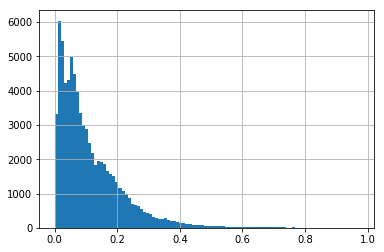

In [390]:
%matplotlib inline
df_to_submit['confidence'].hist(bins=100)

In [391]:
df_to_submit['confidence'] = df_to_submit['confidence'].apply(lambda x: np.log1p(x))
df_to_submit['confidence'] = df_to_submit['confidence'].apply(lambda x: 0 if x<0.0175 else x)
df_to_submit['confidence'] = df_to_submit['confidence'].apply(lambda x: 1 if x>0.65 else x)

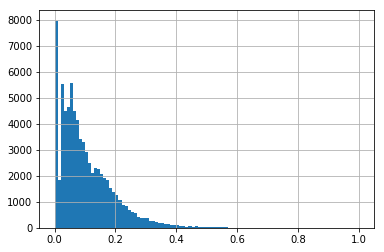

In [392]:
%matplotlib inline
df_to_submit['confidence'].hist(bins=100)

# Submissions

In [393]:
def send(df_to_submit):
    leaderboard_name = "armis"
    host = "leaderboard.datahack.org.il"
    # Name of the user
    submitter = "Itzikim"
    arr_to_submit = df_to_submit.to_json(orient='values')
    predictions = json.loads(arr_to_submit)

    jsonStr = json.dumps({'submitter': submitter, 'predictions': predictions})
    data = jsonStr.encode('utf-8')
    req = request.Request("https://"+host+"/"+leaderboard_name+"/api/",headers={'Content-Type': 'application/json'},data=data)
    resp = request.urlopen(req)
    return json.loads(resp.read().decode('utf-8'))['score']


In [394]:
send(df_to_submit)

0.9059990685549788

## Random Search Submission

In [395]:
max_score = 0
max_params = None
all_scores = []

ntrees = [75, 150, 250]
max_samples = ['auto', 0.1, 0.3]
max_features = range(1, 3)
contamination = ['auto', 0.05, 0.1]
tree_features = sorted(product(ntrees, max_samples, max_features, contamination), key=lambda k: random.random())

features_baseline = \
[
'std_packets_count_sent_out',
'std_out_no_in',
'manous_ratio_mean',
'total_degree',
'out_degree']

features_superset = features_baseline.copy()
num_features = len(features_superset)
feature_staleness = 0
tree_staleness = 0
max_score = 0


while (num_features >= 5) and (feature_staleness <= 3):
    features_subset = random.sample(features_superset,num_features)

    for tree, samples, max_f, contam in tqdm(tree_features):
        anomalous_fs = create_submission(regular_selected,timenorm_selected,features_subset)
        df_to_submit = pd.concat(anomalous_fs)[["network_id", "device_id", "confidence"]] 
        score = send(df_to_submit)

        all_scores.append((score, tree, samples, max_f, contam, num_features, feature_staleness, tree_staleness))    
        print(score, tree, samples, max_f, contam, num_features, feature_staleness, tree_staleness)

        if score > max_score:
            tree_staleness = 0
            feature_staleness = 0
            max_score = score
            max_params = tree, samples, max_f, contam, num_features
            max_features = features_subset.copy()
            print('NEW BEST:', max_score, max_params)
            if max_score > 0.7:
                df_to_submit.to_csv('model_grid_params_{tree}_{samples}_{max_f}_{contam}_{num_features}_{score}.csv'.format(tree,samples,max_f,contam,num_features,score))
        else:
            tree_staleness = tree_staleness + 1

        if tree_staleness > 4:
            break

    if len(features_superset) == len(features_subset):
        feature_staleness = feature_staleness + 1

    features_superset = features_subset.copy()
    num_features = num_features-1

